In [1]:
import numpy as np
import scipy as scp
from scipy import integrate as intg
from scipy import signal 
import time
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors as mclr

rng = np.random.default_rng()

spin_one_matrices = [ np.array([[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]],dtype=complex), 1./np.sqrt(2.)*np.array([[0.,1.,0.],[1.,0.,1.],[0.,1.,0.]],dtype=complex),1./np.sqrt(2.)*np.array([[0.,-1.j,0.],[1.j,0.,-1.j],[0.,1.j,0.]],dtype=complex),np.array([[1.,0.,0.],[0.,0.,0.],[0.,0.,-1.]],dtype=complex) ]


In [78]:
##########################################
####### Wavefunction initilizaiton #######
##########################################

### This initializes a wavefunction on Lx x Ly grid in the Mott state 
def initialize_Mott(Lx,Ly):
	wf = np.zeros((3,Lx,Ly),dtype=complex) ### 3 components for each site, LxxLy sites 

	### According to the parameterization using the spin-one matrices above the charge operator is S^z and thus the [1] component is  the |0> Fock state 
	wf[1,...] = 1.+0.j 

	return wf 

### This initializes a wavefunction on Lx x Ly grid in the superfluid state with a chosen phase 
def initialize_SF(Lx,Ly,phase):
	wf = np.zeros((3,Lx,Ly),dtype=complex) ### 3 components for each site, LxL sites

	wf[:,...] = [ np.exp(1.j*phase), np.sqrt(2.), np.exp(-1.j*phase) ]

	return wf 


### This takes the wavefunction overlap and returns it resolved in space
def overlap(w1,w2):
    return np.sum( np.conjugate(w1)*w2,axis=0)


### This evaluates the magnetization <S> on each site 
### Returns a tensor <S>[c,x,y] with c = 0,1,2,3 the component 
def magnetization(wf):
	Lx,Ly = wf.shape[-2:]
	out = np.zeros((4,Lx,Ly))

    nrom = 

	for i in range(4):
		out[i,...] = np.real( np.sum( np.conjugate(wf) * np.tensordot(spin_one_matrices[i],wf,axes=(1,0)),axis=0) )/

	return out

### This evaluates the magnetization <S> on each site 
### Returns a tensor <S>[c,x,y] with c = 0,1,2,3 the component 
def charge_squared(wf):
	Lx,Ly = wf.shape[-2:]
	out = np.real( np.sum( np.conjugate(wf) * np.tensordot(spin_one_matrices[3]@spin_one_matrices[3], wf,axes=(1,0)),axis=0) )
    
	return out  



### Evaluates the total energy of an ansatz wavefunction for given Ec and Ej parameters 
### These may be arrays 
def energy(wf,Ec,Ej):
    charging_energy = Ec*np.sum( charge_squared(wf) )
    
    m = magnetization(wf)
    Josephson_energy = -Ej*sum([ sum([ np.sum( m[i,...]*np.roll(m[i,...],shift=s,axis=[0,1]) ) for i in [1,2] ]) for s in [ [1,0],[0,1] ] ])
    
    return charging_energy + Josephson_energy
















0.0


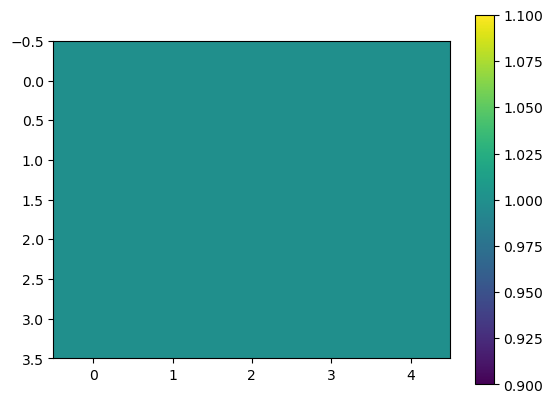

In [81]:
Lx = 4
Ly = 5
wf = initialize_Mott(Lx,Ly)
print(energy(wf,1.,2.))
plt.imshow(np.real(overlap(wf,wf)))
plt.colorbar()
plt.show()



In [45]:
m = np.sum( np.conjugate(wf) * np.tensordot(spin_one_matrices[1],wf,axes=(1,0)),axis=0)
print(m.shape)

(4, 5)


In [44]:
print(n.shape)

(3, 3, 3)
